In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import seaborn as sns

In [2]:
def safelog(vals):
    return np.log(np.maximum(vals, 1e-10))
    
def normalize(vals):
    return vals / np.sum(vals, axis=1, keepdims=True)

def generate_lexicons(n_words, n_meanings):
    arrays =  np.array([list(map(int, list(np.binary_repr(i, width=n_words*n_meanings)))) 
                        for i in range(2**(n_words*n_meanings))])
    lexicons = arrays.reshape((2**(n_words*n_meanings), n_words, n_meanings))
    return lexicons[lexicons.sum(axis=1).min(axis=1) > 0]

def lex_to_str(l):
    return ''.join(map(str, l.reshape(l.shape[0] * l.shape[1])))

In [3]:
class BaseRSA:
    def __init__(self, alpha, prior, C, contexts):
        self.contexts = contexts
        self.alpha = alpha
        self.prior = prior
        self.C = C

    @staticmethod
    def safelog(vals):
        with np.errstate(divide='ignore'):
            return np.log(vals)

    @staticmethod
    def normalize(vals):
        return np.nan_to_num(vals / np.sum(vals, axis=-1, keepdims=True))
    
    def L_0(self, L, c):
        if c is None:
            return self.normalize(L * self.prior)
        return self.normalize(L * self.prior * self.contexts[c])
    
    def S_p(self, L, c=None):
        if c is None:
            return self.normalize(np.exp(self.alpha * (self.safelog(self.L_0(L, c).transpose(0, 2, 1)) - self.C)))
        return self.normalize(np.exp(self.alpha * (self.safelog(self.L_0(L, c).transpose(0, 2, 1)) - self.C)))
    
    def L_p(self, L, c=None):
        if c is None:
            return self.normalize(self.S_p(L, c).transpose(0, 2, 1) * self.prior)
        return self.normalize(self.S_p(L, c).transpose(0, 2, 1) * self.prior * self.contexts[c])

class Agent(BaseRSA):
    def __init__(self, alpha, prior, C, n_words, n_meanings, contexts):
        super().__init__(alpha, prior, C, contexts)
        self.Lexicons = generate_lexicons(n_words, n_meanings)
        self.prob_lexicon = np.ones(len(self.Lexicons)) / len(self.Lexicons)
        self.n_words = n_words
        self.n_meanings = n_meanings
    
    def speaker(self, m, c):
        # index of the lexicon with the highest probability given prob_lexicon
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        return self.S_p(self.Lexicons, c)[lexicon_idx][m].argmax()
    
    def listener(self, w, c):
        # index of the lexicon with the highest probability given prob_lexicon
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        return self.L_p(self.Lexicons, c)[lexicon_idx][w].argmax()
    
    def update(self, w, m, c):
        # self.prob_lexicon = self.normalize(self.L_p(self.Lexicons, c)[:, w, m] * self.prob_lexicon + 1e-5)
        self.prob_lexicon = self.normalize(self.L_0(self.Lexicons, c)[:, w, m] * self.prob_lexicon + 1e-5)

    def max_prob_L(self):
        return lex_to_str(self.Lexicons[np.argmax(self.prob_lexicon)])

In [47]:
prior = np.array([1, 1, 1])
prior = prior / np.sum(prior)
alpha = 1
C = np.array([0, 20])
contexts = np.array([[1, 1, 0], [1, 0, 1]])

In [48]:
ag = Agent(alpha, prior, C, 2, 3, contexts)
ag.max_prob_L()

'000111'

In [49]:
def one_round(a, b, m, c):
    w = a.speaker(m, c)
    g = b.listener(w, c)
    if m == g:
        a.update(w, m, c)
        b.update(w, m, c)
    return m == g, w, g

In [50]:
posteriors = []
logs = defaultdict(lambda: defaultdict(dict))

for t in range(500):
    a = Agent(alpha, prior, C, 2, 3, contexts)
    b = Agent(alpha, prior, C, 2, 3, contexts)

    for _ in range(100):
        m = np.random.choice([0, 1, 2], p=prior)
        logs[t][_]['meaning'] = m
        # if meaning is 0, context is either 0 or 1, if 1, context is 0, if 2 context is 1
        c = np.random.choice([0, 1]) if m == 0 else m - 1
        logs[t][_]['context'] = c
        if _ % 2 == 0:
            tr, w, g = one_round(a, b, m, c)
            logs[t][_]['word'] = w
            logs[t][_]['guess'] = g
            logs[t][_]['correct'] = 1 if tr else 0
            logs[t][_]['lexicon_a'] = a.max_prob_L()
            logs[t][_]['lexicon_b'] = b.max_prob_L()
        else:
            tr, w, g = one_round(b, a, m, c)
            logs[t][_]['word'] = w
            logs[t][_]['guess'] = g
            logs[t][_]['correct'] = 1 if tr else 0
            logs[t][_]['lexicon_a'] = a.max_prob_L()
            logs[t][_]['lexicon_b'] = b.max_prob_L()

    posteriors.append(a.prob_lexicon)
    posteriors.append(b.prob_lexicon)

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_43807/2482417521.py:15: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(vals / np.sum(vals, axis=-1, keepdims=True))


In [51]:
# logs to df
df = pd.DataFrame.from_dict({(i,j): logs[i][j]
                            for i in logs.keys()
                            for j in logs[i].keys()},
                            orient='index').reset_index()
df.columns = ['trial', 'round', 'meaning', 'context', 'word', 'guess', 'correct', 'lexicon_a', 'lexicon_b']
# only keep lexicons where the average accuracy over the last 80 rounds is > 2/3
df = df[df.groupby('trial')['correct'].transform(lambda x: x.iloc[-80:].mean()) > 2/3]
df.shape

(50000, 9)

In [52]:
# only keep last entries of lexicon_a and lexicon_b for each trial but keep the rest intact
df_ = df.sort_values(['trial', 'round']).groupby('trial').tail(1).reset_index(drop=True)
# create a trial - lexicon dictionary
trial_lexicon = dict(zip(df_.trial, df_.lexicon_a))
# add lexicon column to df
df['lexicon'] = df.trial.map(trial_lexicon)

In [53]:
# group rounds by 4
df['round_group'] = df['round'] // 4

Text(0, 0.5, 'Percentage')

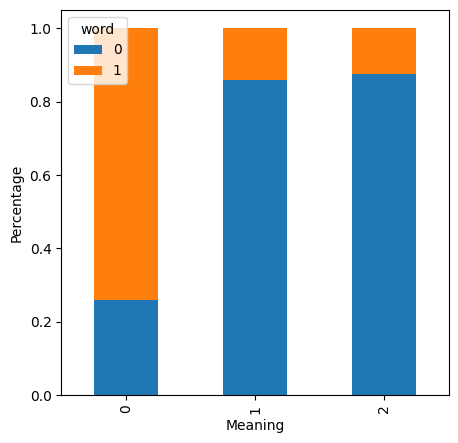

In [54]:
# plot a meaning - word heatmap with number of times this combination was used using matplotlib and convert to percentage
fig, ax = plt.subplots(figsize=(5, 5))
df.groupby(['meaning', 'word'])['word'].count().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Meaning')
ax.set_ylabel('Percentage')

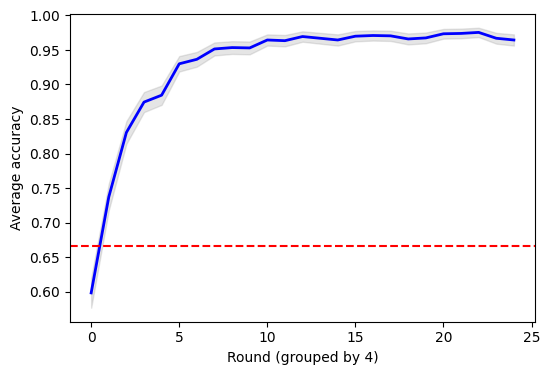

In [55]:
# compute the confidence interval over average accuracy 
df['acc'] = df.groupby(['round_group'])['correct'].transform(lambda x: x.mean())
df['acc_ci'] = df.groupby(['round_group'])['correct'].transform(lambda x: 1.96 * x.std() / np.sqrt(len(x)))
# plot it with the confidence interval as a grey area
df.groupby('round_group')['acc'].mean().plot(linewidth=2, color='blue', figsize=(6, 4))
plt.fill_between(df.round_group.unique(), df.groupby('round_group')['acc'].mean() - df.groupby('round_group')['acc_ci'].mean(), 
                df.groupby('round_group')['acc'].mean() + df.groupby('round_group')['acc_ci'].mean(), alpha=0.2, color='grey')
# add horizontal line at 2/3
plt.axhline(2/3, color='red', linestyle='--')
plt.xlabel('Round (grouped by 4)')
plt.ylabel('Average accuracy')
plt.show()

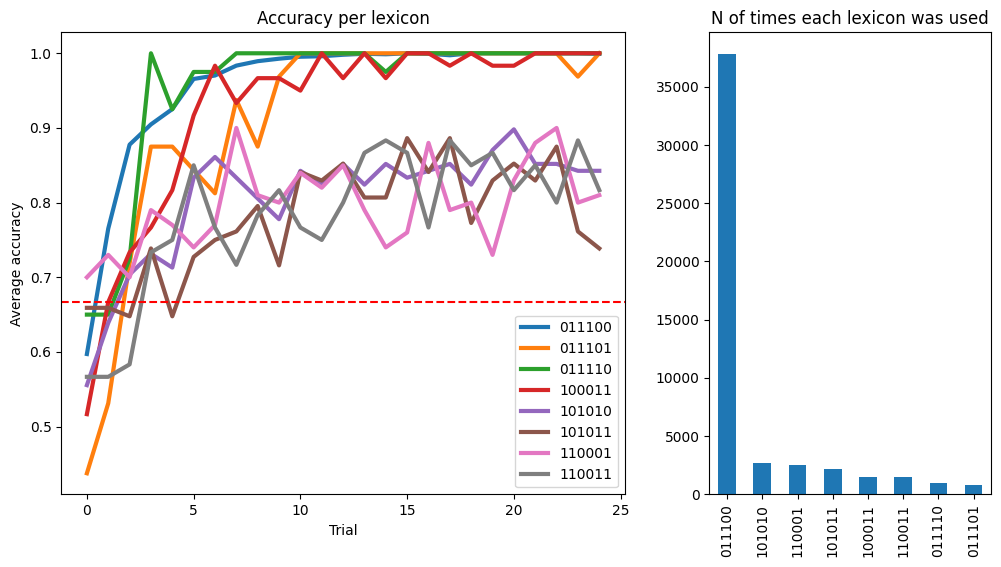

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), width_ratios=[2, 1])
df.groupby(['round_group', 'lexicon']).correct.mean().unstack().plot(ax=ax[0], legend=False, linewidth=3)
ax[0].set_xlabel('Trial')
ax[0].set_ylabel('Average accuracy')
ax[0].set_title('Accuracy per lexicon')
ax[0].axhline(2/3, color='r', linestyle='--')
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels)
df.lexicon.value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('N of times each lexicon was used')
plt.show()


In [57]:
posteriors = np.sum(posteriors, axis=0)
posteriors = posteriors / np.sum(posteriors)

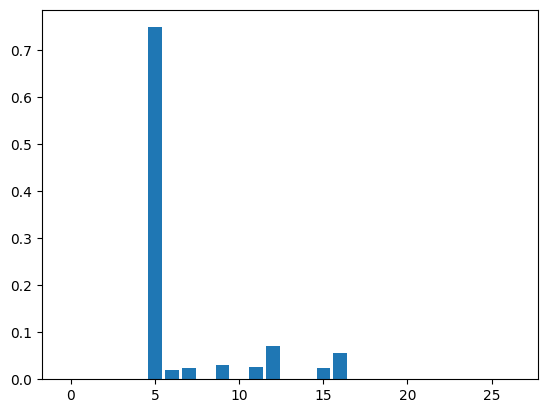

In [58]:
# plot the posterior distribution of the lexicons
plt.bar(np.arange(len(posteriors)), posteriors)
plt.show()

In [59]:
# get the lexicon with the highest probability
lexicon_idx = np.argmax(posteriors)
print(a.Lexicons[lexicon_idx])

[[0 1 1]
 [1 0 0]]


In [60]:
# print top 4 lexicons in the posterior distribution
for i in np.argsort(posteriors)[::-1][:6]:
    print(a.Lexicons[i])

[[0 1 1]
 [1 0 0]]
[[1 0 1]
 [0 1 1]]
[[1 1 0]
 [0 1 1]]
[[1 0 0]
 [0 1 1]]
[[1 0 1]
 [0 1 0]]
[[1 1 0]
 [0 0 1]]


In [61]:
l = pd.DataFrame(a.Lexicons[lexicon_idx], columns=['m1', 'm2', 'm3'], index=['w1', 'w2'])
# add row with prior
l.loc['prior'] = prior
# add column with costs (account for one new row)
l['costs'] = np.append(C, 0)
l

,m1,m2,m3,costs
w1,0.000000,1.000000,1.000000,0
w2,1.000000,0.000000,0.000000,20
prior,0.331126,0.334437,0.334437,0


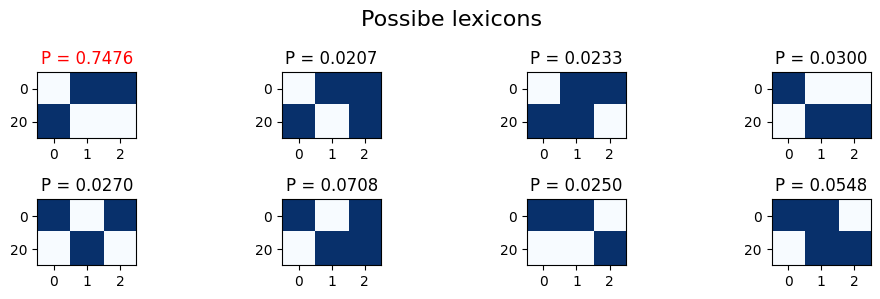

In [62]:
# get the lexicons with the posterior probabilities higher that 1e-5
prob_lexicons = posteriors[posteriors > 0.01]
un_lex = a.Lexicons[posteriors > 0.01]

dim = round(np.sqrt(len(un_lex))) + 1
 
# To-do: need to sort by probability
fig, ax = plt.subplots(dim, dim, figsize=(10, 5))
for i, lex in enumerate(un_lex):
    ax[i//dim, i%dim].imshow(lex, cmap='Blues')
    ax[i//dim, i%dim].xaxis.set_ticks([0, 1, 2])
    ax[i//dim, i%dim].yaxis.set_ticks([0, 1], C)
    ax[i//dim, i%dim].set_aspect('equal')
    ax[i//dim, i%dim].title.set_text(f'P = {prob_lexicons[i]:.4f}')
    # make the title red for the lexicon with maximum probability
    if prob_lexicons[i] == max(prob_lexicons):
        ax[i//dim, i%dim].title.set_color('red')
# if there is lexicon that 16, remove the remaining axes
if len(un_lex) < dim**2:
    for i in range(len(un_lex), dim**2):
        fig.delaxes(ax[i//dim, i%dim])
fig.tight_layout()
# add title
fig.suptitle('Possibe lexicons', fontsize=16, y=1.05)
# save as pdf
fig.savefig('../../figures/possible_lexicons.pdf', bbox_inches='tight')